### Complex Problem Color Classification

### Imports

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import pandas as pd
from collections import Counter

### Data Prep

In [2]:
data = pd.read_csv('data/train.csv')
data.head()

,x,y,color
0,2.375386,-2.151675,0.0
1,0.155175,-3.939919,1.0
2,0.580631,-2.425793,1.0
3,2.045291,-2.755232,0.0
4,0.637783,-1.396165,1.0


In [3]:
data.color.unique()

array([0., 1.])

In [4]:
class Colors(Dataset):
    def __init__(self,path, transform=None, shuffle=False):
        self.path = path
        self.transform = transform
        self.dataFrame = pd.read_csv(path)
        self.xy = pd.read_csv(path).values
        self.shuffle = shuffle
        
        if self.shuffle:
            np.random.shuffle(self.xy)
    
        self.x = self.xy[:, :2]
        self.y = self.xy [:, -1]
        self.len = self.y.shape[0]
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        sample = self.x[index], self.y[index]
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def plot(self):
        sns.scatterplot(data=self.dataFrame, x='x', y='y',hue='color')
        plt.show()

### Transformers

In [5]:
class ToTensor:
    def __call__(self, samples):
        x, y = samples
        return torch.from_numpy(x.astype('float32')) ,torch.from_numpy(np.array(y)).long()

In [6]:
train = Colors(
    'data/train.csv',
    transform =ToTensor(),
    shuffle=True
)
test = Colors(
    'data/test.csv',
    ToTensor(),
    shuffle=True
)

In [7]:
train[:9]

(tensor([[-0.5337, -0.9992],
         [-2.7782,  3.7404],
         [-2.5971,  3.7215],
         [ 1.3819, -3.5847],
         [ 1.8098, -0.5034],
         [ 1.3921, -1.3242],
         [ 1.8007,  1.5332],
         [-3.1029, -2.3260],
         [-2.7284,  4.3812]]),
 tensor([0, 1, 1, 0, 1, 0, 0, 1, 1]))

> Train plot

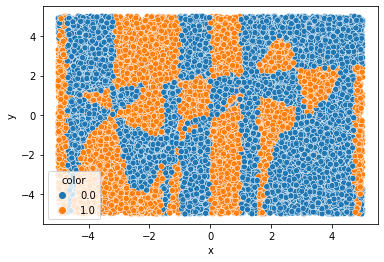

In [8]:
train.plot()

> Test Plot

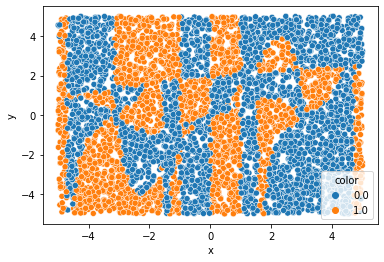

In [9]:
test.plot()

### Data Loading

In [10]:
train_set = DataLoader(dataset=train,
                      batch_size =10,
                      shuffle=True)
test_set = DataLoader(dataset=test,
                      batch_size =10,
                      shuffle=False)

### Model Creation

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
net = Net()
net

Net(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

In [12]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [13]:
def accuracy(y_pred, y_true):
    total = 0
    correct = 0
    y_pred_ = torch.round_(y_pred.squeeze_())
    for i in range(len(y_true)):
        if y_pred_[i] == y_true[i]:
            correct +=1
        total +=1
    return correct/total
    

In [14]:
EPOCHS = 100
for epoch in range(EPOCHS):
    y_true = None
    y_pred = None
    for X, y  in train_set:
        optimizer.zero_grad()
        # forward pass 
        outputs = net(X)
        #loss calc
        y_true = y
        y_pred = outputs
        loss = criterion(outputs, y.type(torch.FloatTensor).unsqueeze_(1))
        # backward pass
        loss.backward()
        # update the weights
        optimizer.step() 
    if (epoch + 1) % 10 == 0:
        accu = accuracy(y_pred, y_true)
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print(f"loss: {loss.item():.3f}, accuracy: {accu:.3f}")

Epoch 10/100
loss: 0.689, accuracy: 0.900
Epoch 20/100
loss: 0.209, accuracy: 0.900
Epoch 30/100
loss: 0.310, accuracy: 0.900
Epoch 40/100
loss: 0.337, accuracy: 0.700
Epoch 50/100
loss: 0.148, accuracy: 1.000
Epoch 60/100
loss: 0.518, accuracy: 0.600
Epoch 70/100
loss: 0.220, accuracy: 0.900
Epoch 80/100
loss: 0.325, accuracy: 0.700
Epoch 90/100
loss: 0.414, accuracy: 0.700
Epoch 100/100
loss: 0.104, accuracy: 1.000


### Evaluating the Model

In [15]:
total = 0
correct = 0
with torch.no_grad():
    for data in test_set:
        X, y = data
        output = torch.argmax(net(X), dim=1)
        for i in range(len(y)):
            if output[i] == y[i]:
                correct +=1
            total+=1
    print("Accuracy: ", correct/total)

Accuracy:  0.5788


### Making Predictions

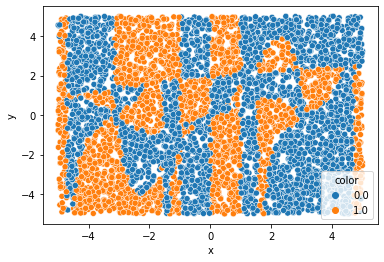

In [17]:
test.plot()

In [26]:
net(torch.Tensor([4, -10.]))

tensor([1.2565e-16], grad_fn=<SigmoidBackward>)